In [245]:
import pandas as pd
import geopandas as gp 
import json
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gp
sns.set(rc={'figure.figsize':(12,8)})
plt.style.use('default')
%matplotlib inline
from tqdm import tqdm
import glob
import numpy as np
from scipy.stats import pearsonr
from scipy.stats import linregress
import pickle as pkl

In [2]:
files = glob.glob('../BL_Work/openPrescribe/savings_Impact/*.h5')
files.sort()
print files

['../BL_Work/openPrescribe/savings_Impact/201406.h5', '../BL_Work/openPrescribe/savings_Impact/201407.h5', '../BL_Work/openPrescribe/savings_Impact/201408.h5', '../BL_Work/openPrescribe/savings_Impact/201409.h5', '../BL_Work/openPrescribe/savings_Impact/201410.h5', '../BL_Work/openPrescribe/savings_Impact/201411.h5', '../BL_Work/openPrescribe/savings_Impact/201412.h5', '../BL_Work/openPrescribe/savings_Impact/201501.h5', '../BL_Work/openPrescribe/savings_Impact/201502.h5', '../BL_Work/openPrescribe/savings_Impact/201503.h5', '../BL_Work/openPrescribe/savings_Impact/201504.h5', '../BL_Work/openPrescribe/savings_Impact/201505.h5', '../BL_Work/openPrescribe/savings_Impact/201506.h5', '../BL_Work/openPrescribe/savings_Impact/201507.h5', '../BL_Work/openPrescribe/savings_Impact/201508.h5', '../BL_Work/openPrescribe/savings_Impact/201509.h5', '../BL_Work/openPrescribe/savings_Impact/201510.h5', '../BL_Work/openPrescribe/savings_Impact/201511.h5', '../BL_Work/openPrescribe/savings_Impact/2015

In [3]:
pdp = pd.read_hdf(files[0])

In [4]:
# %store -r opiod_BNF
%store -r antiDM_BNF
%store -r opiod_BNF
%store -r antiDep_BNF

In [5]:
%store -r STD_bnf

In [6]:
len(STD_bnf)

25

In [7]:
LSOA_dist = json.load(open('scratchpad/GP_LSOA_PATIENTSDIST.json','rb'))

In [8]:
STD_bnf.head()

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
1127,1127,0501011I0,Benzylpenicillin (Penicillin G) ...,Q42T66VG0C
1128,1128,0501011J0,Benzylpenicillin Sodium (Penicillin G) ...,Q42T66VG0C
1132,1132,0501011T0,Procaine Benzylpenicillin ...,Q42T66VG0C
1134,1134,0501011W0,Benethamine Penicillin/Benzylpenicillin ...,Q42T66VG0C
1183,1183,0501021G0,Ceftriaxone Sodium ...,75J73V1629


In [9]:
ward_pop = pd.read_csv('scratchpad/ward_pop.csv')

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (23,24,25,26,27,28,29,30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
GP_META = pd.read_csv('../BL_Work/epraccur.csv',header=None)
GP_META.rename(columns={0:'BP_code',
                        1:'Name',
                        2:'Grouping',
                        3:'National_geo',
                        4:'Addr1',
                        5:'Addr2',
                        6:'Addr3',
                        7: 'Addr4',
                        8:'Addr5',
                        9:'Postcode',
                        10:'Open',
                        11:'Closed',
                        12:'Status',
                        13:'Org type code',
                        14:'Commissioner',
                        15:'Join provider',
                        16:'Left provider',
                        17:'Contact',
                        18:'Null1',
                        19:'Null2',
                        20:'Null3',
                        21:'Amended',
                        22:'Null4',
                        23:'Provider',
                        24:'Null5',
                        25:'Setting',
                        26:'Null6'}, 
                 inplace=True)

In [11]:
Open_filtered_GPs = {}
for index,row in GP_META.iterrows():
    if row ['Setting'] == 4 and row['Status'] =='A':
        Open_filtered_GPs[row['BP_code']] = row['Postcode'].strip()

In [12]:
population = {}
for index, row in ward_pop.iterrows():
    population[row['Ward Code 1']] = float(row['All Ages'].replace(',',''))

In [13]:
population_borough = {}
for name,group in ward_pop.groupby('Local Authority'):
    population_borough[name] = 0.0
    for index , row in group.iterrows():
        population_borough[name] += float(row['All Ages'].replace(',',''))

In [14]:
pdp.head()

Unnamed: 0    0    1       2                3  \
0 34712       43870  Q44  01R  N81016  0101010C0BBAAAA   
  47626       56784  Q44  01R  N81068  0101010C0BBAAAA   
  50737       59895  Q44  01R  N81084  0101010C0BBAAAA   
  55199       64357  Q44  01R  N81614  0101010C0AAAAAA   
  74259       83978  Q44  02D  N81127  0101010C0BBAAAA   

                                                4    5      6      7      8  \
0 34712  Alu-Cap_Cap 475mg                         1.0  27.42  25.34  240.0   
  47626  Alu-Cap_Cap 475mg                         1.0  41.13  38.00  360.0   
  50737  Alu-Cap_Cap 475mg                         1.0  54.84  50.66  480.0   
  55199  Alum Hydrox_Cap 475mg                     1.0  13.71  12.66  120.0   
  74259  Alu-Cap_Cap 475mg                         1.0  38.39  35.57  336.0   

         ...     15         16    17   18    19  20     21        22   23  \
0 34712  ...  475.0  0101010C0  20.0  1.0  20.0  BB  0.115  0.110952  0.0   
  47626  ...  475.0  0101010C0  30.0  1.0  30.0  BB  0.115  0.110952  0.0   
  50737  ...  475.0  0101010C0  40.0  1.0  40.0  BB  0.115  0.110952  0.0   
  55199  ...  475.0  0101010C0  10.0  1.0  10.0  AA  0.115  0.110952  0.0   
  74259  ...  475.0  0101010C0  28.0  1.0  28.0  BB  0.115  0.110952  0.0   

               24  
0 34712  1.979167  
  47626  1.319444  
  50737  0.989583  
  55199  3.958333  
  74259  1.413690  

[5 rows x 26 columns]

In [15]:
def func_ome(df,drugBNF,ome_map):
    df['presc_ome'] = df['8'] *df['15']*ome_map[drugBNF]
    return df

def calculateOME(pdp,ome_map):
    pdp['presc_ome'] = 0.0
    return pdp.groupby('3',as_index=False).apply(lambda df: func_ome(df , df.name, ome_map ))

%store -r ome_map

opioids = pdp[pdp['3'].isin(ome_map.keys())]
opioids = calculateOME(opioids , ome_map) 

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
# rantadine = pdp.loc[pdp['16'] == '0601023B0']

In [17]:
# rantadine.head()

In [18]:
# min(rantadine['15'])

In [19]:
# opioids = pdp.loc[pdp['16'].isin(STD_bnf['BNF_code'])]
# opioids = pdp

In [20]:
opioids.head()

Unnamed: 0    0    1       2                3  \
494 113277       125692  Q44  02F  N81006  040702020BBABAB   
    167785       183942  Q44  12F  N85008  040702020BBABAB   
    240901       267479  Q45  00D  A83001  040702020BBABAB   
    1347159     1525127  Q48  01V  N84014  040702020AAABAB   
    1352084     1530052  Q48  01V  N84021  040702020BBAAAA   

                                                    4     5       6       7  \
494 113277   Cyclimorph 15_Inj 1ml Amp                  1.0    1.82    1.68   
    167785   Cyclimorph 15_Inj 1ml Amp                  4.0  109.44  101.12   
    240901   Cyclimorph 15_Inj 1ml Amp                  1.0    3.65    3.48   
    1347159  Morph/Cyclizine_Inj 15mg/50mg 1ml Amp     10.0   89.36   83.05   
    1352084  Cyclimorph 10_Inj 1ml Amp                  2.0   87.70   81.02   

                8  ...         16    17   18     19  20    21    22     23  \
494 113277    1.0  ...  040702020   1.0  1.5    1.5  BB  1.00  1.68   0.68   
    167785   60.0  ...  040702020  60.0  1.5   90.0  BB  1.00  1.68  40.80   
    240901    2.0  ...  040702020   2.0  1.5    3.0  BB  1.00  1.68   1.36   
    1347159  49.0  ...  040702020  49.0  5.0  245.0  AA  1.62  1.00   0.00   
    1352084  50.0  ...  040702020  50.0  1.0   50.0  BB  1.00  1.62  31.00   

                    24  presc_ome  
494 113277   15.000000       30.0  
    167785    0.250000     1800.0  
    240901    7.500000       60.0  
    1347159   1.020408     4900.0  
    1352084   0.200000     1000.0  

[5 rows x 27 columns]

In [21]:
non_generic_opioid = opioids.loc[opioids['20']!='AA']

In [22]:
sum(non_generic_opioid['23'])

2206821.9233728056

In [23]:
sum(opioids['7'])

20291599.329997547

In [24]:
len(non_generic_opioid), len(opioids)

(93575, 253555)

In [25]:
GP_postcodes_long = {}
for name , group in non_generic_opioid.groupby('2'):
    postcode = list(set(group['10']))
    GP_postcodes_long[name] = str(postcode[0]).strip()

In [26]:
ward_df = pd.read_csv('../BL_Work/pcd11_par11_wd11_lad11_ew_lu.csv')

# ward_df.head()

ward_postcode_map = {}
for name, group in ward_df.groupby('wd11cd'):
    ward_postcode_map[name] = list(group['pcds'])

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (5,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
LSOA_savings = {}

for name, group in tqdm(non_generic_opioid.groupby('2')):
    total_saving = np.sum(group['23'])
    if name in LSOA_dist:        
        for k in LSOA_dist[name]:
            if k not in LSOA_savings:
                LSOA_savings[k] = 0.0
            LSOA_savings[k]+= float(total_saving)*float(LSOA_dist[name][k])

100%|██████████| 6662/6662 [00:04<00:00, 1640.54it/s]


In [28]:
%store -r Ward_prevalence
%store -r Ward_patients
%store -r DiseasePop_byWard

In [29]:
df = pd.read_csv('../BL_Work/Lower_Layer_Super_Output_Area_2011_to_Ward_2015_Lookup_in_England_and_Wales.csv')

In [30]:
wardMap = {}
for name , group in df.groupby('WD15CD'):
        wardMap[name] = list(group['LSOA11CD'])

In [31]:
boroughMap = {}
for name , group in df.groupby('LAD15NM'):
        boroughMap[name] = list(group['LSOA11CD'])

In [32]:
population_borough = {}
for name,group in ward_pop.groupby('Local Authority'):
    population_borough[name] = 0.0
    for index , row in group.iterrows():
        population_borough[name] += float(row['All Ages'].replace(',',''))

In [33]:
borough_savings_UK = {}

for k in boroughMap:
    try:
        borough_savings= np.sum([LSOA_savings[w] for w in boroughMap[k] if not np.isnan(LSOA_savings[w])])
        pop = population_borough[k]
        borough_savings_UK[k] = (float(borough_savings)/float(pop))*1000.0
        
    except:
        print "Some ward had wrong data"

Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data
Some ward had wrong data


In [34]:
borough_savings_UK

{'Adur': 33.502830436957524,
 'Allerdale': 46.867872587095704,
 'Amber Valley': 21.414520601670535,
 'Arun': 29.612475353139093,
 'Ashfield': 38.43040172741964,
 'Ashford': 67.8716731189959,
 'Aylesbury Vale': 24.932180491847618,
 'Babergh': 55.756371363501884,
 'Barking and Dagenham': 13.401598017830006,
 'Barnet': 15.482422413621867,
 'Barnsley': 22.99525527011535,
 'Barrow-in-Furness': 47.96451292114356,
 'Basildon': 49.661571141184375,
 'Basingstoke and Deane': 41.31680157938867,
 'Bassetlaw': 31.2028563226816,
 'Bath and North East Somerset': 30.506271061470734,
 'Bedford': 29.204365074929246,
 'Bexley': 34.40194742752057,
 'Birmingham': 27.62601521028794,
 'Blaby': 35.690905398294824,
 'Blackburn with Darwen': 28.790777506388245,
 'Blackpool': 35.21608068124618,
 'Bolsover': 42.66656095981203,
 'Bolton': 62.96392125662993,
 'Boston': 94.37759701752735,
 'Bournemouth': 39.074734286264686,
 'Bracknell Forest': 22.767054578561684,
 'Bradford': 33.2521192322796,
 'Braintree': 67.7832

In [35]:
%store -r cityMap 
%store -r cityPop

In [36]:
# cityMap

In [37]:
len(cityPop)

109

In [218]:
def calculateTemporalMetrics(all_presc, non_generic,  population_borough):
    LSOA_savings = {}
    LSOA_dosage = {}
    LSOA_costs = {}
    fail = 0.0
    for name, group in all_presc.groupby('2'):
#         _total_dosage = np.sum(group['24'])
#         _total_dosage = np.sum(group['presc_ome'])
        total_dosage = np.sum(group['5'])
#         total_dosage = len(group['5'])
        total_cost = np.sum(group['7'])
        if name in LSOA_dist:        
            for k in LSOA_dist[name]:
                if k not in LSOA_dosage:
                    LSOA_dosage[k] = 0.0
                    LSOA_costs[k] = 0.0
                LSOA_dosage[k]+= float(total_dosage)*float(LSOA_dist[name][k])
                LSOA_costs[k]+= float(total_cost)*float(LSOA_dist[name][k])

    for name, group in non_generic.groupby('2'):
        total_saving = np.sum(group['23'])
        if name in LSOA_dist:        
            for k in LSOA_dist[name]:
                if k not in LSOA_savings:
                    LSOA_savings[k] = 0.0
                LSOA_savings[k]+= float(total_saving)*float(LSOA_dist[name][k])

    borough_savings_UK = {}
    borough_dosage_UK = {}
    borough_cost_UK = {}
#     for k in boroughMap:
#         try:
#             borough_savings= np.sum([LSOA_savings[w] for w in boroughMap[k] if not np.isnan(LSOA_savings[w])])
#             borough_dosages= np.sum([LSOA_dosage[w] for w in boroughMap[k] if not np.isnan(LSOA_dosage[w])])
#             borough_costs= np.sum([LSOA_costs[w] for w in boroughMap[k] if not np.isnan(LSOA_costs[w])])

#             pop = population_borough[k]
#             borough_savings_UK[k] = float(borough_savings)
#             borough_dosage_UK[k] = (float(borough_dosages)/float(pop))*1000.0
#             borough_cost_UK[k] = (float(borough_costs)/float(pop))*1000.0

#         except:
#             fail+=1

#calculate city level savings
    for k in cityMap:
        try:
            borough_savings= np.sum([LSOA_savings[w] for w in cityMap[k] if not np.isnan(LSOA_savings[w])])
            borough_dosages= np.sum([LSOA_dosage[w] for w in cityMap[k] if not np.isnan(LSOA_dosage[w])])
            borough_costs= np.sum([LSOA_costs[w] for w in cityMap[k] if not np.isnan(LSOA_costs[w])])

            pop = cityPop[k]
            borough_savings_UK[k] = float(borough_savings)
            borough_dosage_UK[k] = float(borough_dosages)
            borough_cost_UK[k] = (float(borough_costs)/float(pop))*1000.0

        except:
            print("Failed something at "+k)
            fail+=1
    
    return borough_savings_UK , borough_dosage_UK , borough_cost_UK

In [39]:
%store -r category_BNF_map

In [40]:
# category_BNF_map['Antibacterials for Systemic Use']

In [41]:
category_BNF_map.keys()

[u'Posterior Pituitary Lobe Hormones',
 u'Curare Alkaloids',
 u'Breast Cancer Resistance Protein Inhibitors',
 u'Prostacyclin Analogues',
 u'UGT1A1 Substrates',
 u'Lactates',
 u'Caffeine',
 u'BCRP/ABCG2 Inhibitors',
 u'Cytochrome P-450 CYP2B6 Inhibitors (strength unknown)',
 u'Sucrose-specific Enzyme',
 u'Deoxycytidine',
 u'Histamine H2 Antagonists',
 u'Vitamins',
 u'Thiazide-like Diuretic',
 u'HIV Antigens',
 u'Microtubule Inhibition',
 u'Arsenicals',
 u'Phosphinic Acids',
 u'Acyclovir',
 u'Hydroxyquinolines',
 u'Cytochrome P450 3A4 Inhibitors',
 u'Vinca Alkaloids',
 u'OCT1 substrates',
 u'Insecticides and Repellents',
 u'Phosphoramide Mustards',
 u'Decreased Protein Synthesis',
 u'OAT3/SLC22A8 Substrates',
 u'Cytochrome P-450 CYP3A Inhibitors (strong)',
 u'Lipopeptide Antibacterial',
 u'Nitrofuran Derivatives',
 u'Antibiotics, Antitubercular',
 u'Heroin, agonists',
 u'Protein-Lysine 6-Oxidase, antagonists & inhibitors',
 u'Growth Inhibitors',
 u'Insulin, Short-Acting',
 u'Erythropoie

In [42]:
# selectedKeys = ['Vitamins','Histamine H2 Antagonists','Heroin, agonists','Anemia, Iron-Deficiency','Lipids','Dopamine Agents'
#                 ,'Alcohol Deterrents','Nicotine, antagonists & inhibitors','Anti-Obesity Agents','Antibacterials for Systemic Use']
selectedKeys = ['opioids']

In [43]:
sorted_category = sorted(category_BNF_map.items(), key=lambda item: len(item[1]),reverse=True)

In [44]:
# sorted_category[30:40]

In [45]:
# monthly_borough_savings = {k : {} for k in selectedKeys}
# monthly_borough_dosage = {k : {} for k in selectedKeys}
# monthly_borough_costs = {k : {} for k in selectedKeys}

In [46]:
# monthly_borough_savings = {'opioids':{},'dep':{},'diabetes':{}}
# monthly_borough_dosage = {'opioids':{},'dep':{},'diabetes':{}}
# monthly_borough_costs = {'opioids':{},'dep':{},'diabetes':{}}


monthly_borough_savings = {'opioids':{}}
monthly_borough_dosage = {'opioids':{}}
monthly_borough_costs = {'opioids':{}}

In [47]:
files[19]

'../BL_Work/openPrescribe/savings_Impact/201601.h5'

# pdp = pd.read_hdf(files[15])

In [48]:
# for f in tqdm(files[17:29]):
# # for f in tqdm(files):
#     month = f.split('/')[-1].split('.')[0]
#     monthly_borough_savings[month] = {}
#     pdp = pd.read_hdf(f)
    
#     for k in selectedKeys:
#         df_k = pdp.loc[pdp['16'].isin(category_BNF_map[k])]
#         non_generic_k = df_k.loc[df_k['20']!='AA']
#         monthly_borough_savings[k][month], monthly_borough_dosage[k][month] ,monthly_borough_costs[k][month] = calculateTemporalMetrics(df_k , non_generic_k , population_borough)

In [49]:
# pkl.dump(monthly_borough_savings,open('10_Cat_savings.pkl','wb'))

# pkl.dump(monthly_borough_dosage,open('10_Cat_dosage.pkl','wb'))

# pkl.dump(monthly_borough_costs,open('10_Cat_costs.pkl','wb'))

In [149]:
#TAKEN FROM HERE : https://openprescribing.net/bnf/050301/
HIV_drugs = {
    "Abacavir" :"0503010E0",
    "Abacavir & Lamivudine" : "0503010Z0",
    "Abacavir/Lamivudine/Zidovudine" : "0503010F0",
    "Atazanavir" : "0503010L0",
    "Atazanavir & Cobicistat": "0503010AL",
    "Bictegravir/Emtricitabine/Tenofovir Alaf": "0503010AQ",
    "Cobicistat" : "0503010AI",
    "Darunavir" : "0503010AC",
    "Darunavir/Cobicistat" : "0503010AK",
    "Didanosine" : "0503010N0",
    "Dolutegravir" : "0503010AH",
    "Dolutegravir/Rilpivirine" : "0503010AP",
    "Efavirenz" : "0503010D0",
    "Efavirenz/Emtricitabine/Tenofovir Disop" : "0503010AN",
    "Elvitegravir" : "0503010AJ",
    "Emtricitabine" : "0503010K0",
    "Emtricitabine & Tenofovir Alafenamide" : "0503010AM",
    "Emtricitabine & Tenofovir Disoproxil" : "0503010AA",
    "Etravirine" : "0503010AF",
    "Fosamprenavir Calcium" : "0503010M0",
    "Lamivudine" : "0503010Q0",
    "Lamivudine & Zidovudine" : "0503010A0",
    "Lopinavir & Ritonavir" : "0503010G0",
    "Maraviroc" : "0503010AD",
    "Nelfinavir Mesilate" : "0503010C0",
    "Nevirapine" : "0503010B0",
    "Other HIV Infection Preps" : "050301000",
    "Raltegravir" : "0503010AE",
    "Rilpivirine" : "0503010AG",
    "Ritonavir" : "0503010U0",
    "Saquinavir Mesylate" : "0503010R0",
    "Stavudine" : "0503010S0",
    "Tenofovir Disoproxil" : "0503010H0",
    "Tipranavir" : "0503010AB",
    "Zidovudine" : "0503010Y0"
}

In [147]:
hiv_drugs = set(HIV_drugs.values())

In [187]:
hiv_drugs

{'050301000',
 '0503010A0',
 '0503010AA',
 '0503010AB',
 '0503010AC',
 '0503010AD',
 '0503010AE',
 '0503010AF',
 '0503010AG',
 '0503010AH',
 '0503010AI',
 '0503010AJ',
 '0503010AK',
 '0503010AL',
 '0503010AM',
 '0503010AN',
 '0503010AP',
 '0503010AQ',
 '0503010B0',
 '0503010C0',
 '0503010D0',
 '0503010E0',
 '0503010F0',
 '0503010G0',
 '0503010H0',
 '0503010K0',
 '0503010L0',
 '0503010M0',
 '0503010N0',
 '0503010Q0',
 '0503010R0',
 '0503010S0',
 '0503010U0',
 '0503010Y0',
 '0503010Z0'}

In [143]:
opiod_BNF = STD_bnf

In [144]:
opiod_BNF

,Unnamed: 0,BNF_code,NAME,UNII_drugbank
1127,1127,0501011I0,Benzylpenicillin (Penicillin G) ...,Q42T66VG0C
1128,1128,0501011J0,Benzylpenicillin Sodium (Penicillin G) ...,Q42T66VG0C
1132,1132,0501011T0,Procaine Benzylpenicillin ...,Q42T66VG0C
1134,1134,0501011W0,Benethamine Penicillin/Benzylpenicillin ...,Q42T66VG0C
1183,1183,0501021G0,Ceftriaxone Sodium ...,75J73V1629
1199,1199,0501030I0,Doxycycline Hyclate ...,334895S862
1208,1208,0501030Z0,Doxycycline Monohydrate ...,334895S862
1219,1219,0501050A0,Azithromycin ...,J2KLZ20U1M
1221,1221,0501050C0,Erythromycin ...,63937KV33D
1222,1222,0501050F0,Erythromycin Estolate ...,63937KV33D


In [51]:
# files[19:31]

In [216]:

# for f in tqdm(files):
for f in tqdm(files[-24:]):
    month = f.split('/')[-1].split('.')[0]
    monthly_borough_savings[month] = {}
    pdp = pd.read_hdf(f)
    opioids = pdp.loc[pdp['16'].isin(hiv_drugs)] #Original opioids
#     opioids = pdp.loc[pdp['16'].isin(opiod_BNF['BNF_code'])] #Original opioids
#     opioids = pdp[pdp['3'].isin(ome_map.keys())]
#     opioids = calculateOME(opioids , ome_map) 
    
#     anti_dm = pdp.loc[pdp['16'].isin(antiDM_BNF['BNF_code'])]
#     anti_dep = pdp.loc[pdp['16'].isin(antiDep_BNF['BNF_code'])]
    
    non_generic_opioid = opioids.loc[opioids['20']!='AA']
#     non_generic_dm = anti_dm.loc[anti_dm['20']!='AA']
#     non_generic_dep = anti_dep.loc[anti_dep['20']!='AA']

    monthly_borough_savings['opioids'][month], monthly_borough_dosage['opioids'][month] ,monthly_borough_costs['opioids'][month] = calculateTemporalMetrics(opioids , non_generic_opioid , population_borough)
#     monthly_borough_savings['diabetes'][month], monthly_borough_dosage['diabetes'][month] ,monthly_borough_costs['diabetes'][month] = calculateTemporalMetrics(anti_dm , non_generic_dm , population_borough)
#     monthly_borough_savings['dep'][month], monthly_borough_dosage['dep'][month] ,monthly_borough_costs['dep'][month] = calculateTemporalMetrics(anti_dep , non_generic_dep , population_borough)




  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 1/24 [00:25<09:55, 25.90s/it]

  8%|▊         | 2/24 [00:56<10:01, 27.35s/it]

 12%|█▎        | 3/24 [01:23<09:31, 27.20s/it]

 17%|█▋        | 4/24 [01:54<09:27, 28.37s/it]

 21%|██        | 5/24 [02:23<09:04, 28.68s/it]

 25%|██▌       | 6/24 [02:54<08:47, 29.28s/it]

 29%|██▉       | 7/24 [03:24<08:22, 29.54s/it]

 33%|███▎      | 8/24 [03:55<07:59, 29.97s/it]

 38%|███▊      | 9/24 [04:25<07:29, 30.00s/it]

 42%|████▏     | 10/24 [04:56<07:04, 30.32s/it]

 46%|████▌     | 11/24 [05:27<06:34, 30.37s/it]

 50%|█████     | 12/24 [05:58<06:06, 30.56s/it]

 54%|█████▍    | 13/24 [06:29<05:38, 30.75s/it]

 58%|█████▊    | 14/24 [07:01<05:11, 31.11s/it]

 62%|██████▎   | 15/24 [07:31<04:37, 30.84s/it]

 67%|██████▋   | 16/24 [08:03<04:09, 31.13s/it]

 71%|███████   | 17/24 [08:35<03:38, 31.25s/it]

 75%|███████▌  | 18/24 [09:06<03:08, 31.35s/it]

 79%|███████▉  | 19/24 [09:39<02:38, 31.65s/it]

 83%|████████▎ | 20/24 [10:10<02:06,

In [217]:
monthly_borough_dosage

{'opioids': {'201406': {'West Bromwich': 1.471756918759398},
  '201407': {'West Bromwich': 1.492694258827917},
  '201408': {'Middlesbrough': 1.9791801738843504,
   'West Bromwich': 1.5267790554673795},
  '201409': {'West Bromwich': 1.5278784074439158},
  '201410': {'West Bromwich': 1.478413486166151},
  '201411': {'Maidstone': 2.987736433695731,
   'West Bromwich': 1.5097926051259671},
  '201412': {'Basingstoke': 1.8857001802973954,
   'Blackpool': 1.9532338214821623,
   'West Bromwich': 1.9645343311816257},
  '201501': {'Walsall': 4.983760876358634},
  '201502': {'Walsall': 2.347975700800263,
   'West Bromwich': 2.6711501868685517},
  '201503': {},
  '201504': {'West Bromwich': 2.413380157404997},
  '201505': {'Carlisle': 0.875511423633457,
   'West Bromwich': 1.0188653861843162},
  '201506': {'Walsall': 2.336143854425367,
   'West Bromwich': 0.9756146110963072},
  '201507': {'West Bromwich': 1.0147886445325656},
  '201508': {'Gateshead': 1.9148572880097916,
   'West Bromwich': 0.9798

In [188]:
IMD_df = pd.read_csv('../BL_Work/File_7_ID_2015_All_ranks__deciles_and_scores_for_the_Indices_of_Deprivation__and_population_denominators.csv')

In [189]:
# IMD_df.head()

In [190]:
IMD_city = {}
for k in cityMap:
    city_LSOA_IMD = IMD_df[IMD_df['LSOA code (2011)'].isin(cityMap[k])]
    medianIMD_city = np.median(city_LSOA_IMD['Index of Multiple Deprivation (IMD) Score'])
    IMD_city[k] = medianIMD_city
# IMD_city

In [191]:
cityMap

{'Barnsley': ['E01007344',
  'E01007355',
  'E01007356',
  'E01007357',
  'E01007358',
  'E01007359',
  'E01007360',
  'E01007361',
  'E01007362',
  'E01007363',
  'E01007379',
  'E01007380',
  'E01007381',
  'E01007386',
  'E01007387',
  'E01007317',
  'E01007318',
  'E01007319',
  'E01007320',
  'E01007321',
  'E01007322',
  'E01007323',
  'E01007324',
  'E01007325',
  'E01007326',
  'E01007327',
  'E01007334',
  'E01007335',
  'E01007336',
  'E01007337',
  'E01007338',
  'E01007339',
  'E01007340',
  'E01007446',
  'E01007400',
  'E01007402',
  'E01007403',
  'E01007404',
  'E01007405',
  'E01007406',
  'E01007408',
  'E01007409',
  'E01007410',
  'E01007411',
  'E01007413',
  'E01007414',
  'E01007415',
  'E01007416',
  'E01007417',
  'E01007437',
  'E01007441',
  'E01007442',
  'E01007443',
  'E01007444',
  'E01007445',
  'E01032550',
  'E01032551'],
 'Basildon': ['E01021323',
  'E01021324',
  'E01021325',
  'E01021326',
  'E01021327',
  'E01021273',
  'E01021328',
  'E01021274',


In [192]:
%store IMD_city

Stored 'IMD_city' (dict)


In [193]:
len(IMD_city)

112

In [194]:
# json.dump(cityPop,open('City_pop_england.json','w'))

In [195]:
# %store monthly_borough_savings
# %store monthly_borough_dosage
# %store monthly_borough_costs

In [196]:
# pkl.dump(monthly_borough_savings,open('the_three_city_savings.pkl','wb'))

# pkl.dump(monthly_borough_dosage,open('the_three_city_dosage.pkl','wb'))

# pkl.dump(monthly_borough_costs,open('the_three_city_costs.pkl','wb'))

In [197]:
# pkl.dump(monthly_borough_savings,open('the_three_savings.pkl','wb'))

# pkl.dump(monthly_borough_dosage,open('the_three_dosage.pkl','wb'))

# pkl.dump(monthly_borough_costs,open('the_three_costs.pkl','wb'))

In [198]:
# monthly_borough_savings = pkl.load(open('10_Cat_savings.pkl','rb'))

# monthly_borough_dosage  = pkl.load(open('the_three_dosage.pkl','rb'))

# monthly_borough_costs = pkl.load(open('the_three_costs.pkl','rb'))

In [199]:
# len(monthly_borough_savings['opioids']['201201'])

In [200]:
total_savings = {k:0 for k in selectedKeys}
for k in total_savings.keys():
    disease_saving= monthly_borough_savings[k]
    for month in disease_saving:
        total_savings[k]+= np.sum(disease_saving[month].values())
    
print total_savings

{'opioids': 4289.16071372593}


In [201]:
import operator
sorted(total_savings.items(), key=operator.itemgetter(1))

[('opioids', 4289.16071372593)]

In [202]:
# sorted(monthly_borough_savings['Vitamins'].keys())

In [222]:
disease = 'opioids'
cityOverSpending = {}
savings = monthly_borough_savings[disease]
for k in savings:
    for city in savings[k]:
        if city not in cityOverSpending:
            cityOverSpending[city] = savings[k][city]
        else: 
            cityOverSpending[city]+=savings[k][city]
# for k in cityOverSpending:

In [223]:
disease = 'opioids'
cityDosage = {}
savings = monthly_borough_dosage[disease]
for k in savings:
    for city in savings[k]:
        if city not in cityDosage:
            cityDosage[city] = savings[k][city]
        else: 
            cityDosage[city]+=savings[k][city]

In [224]:
cityDosage

{'Basingstoke': 1.8857001802973954,
 'Bedford': 5.7854708810304185,
 'Birkenhead': 2.5616713539574127,
 'Blackpool': 6.816173144650445,
 'Carlisle': 0.875511423633457,
 'Chelmsford': 1.804558754831516,
 'Cheltenham': 2.8728990879812093,
 'Chester': 4.463868991351878,
 'Exeter': 0.9277125711837152,
 'Gateshead': 1.9148572880097916,
 'Grimsby': 3.9657264174624247,
 'Harrogate': 4.893123698100723,
 'Luton': 2.970894908618267,
 'Maidstone': 2.987736433695731,
 'Middlesbrough': 1.9791801738843504,
 'Northampton': 3.856212899700651,
 'Nuneaton': 1.009228314239425,
 'Oxford': 11.501913569565064,
 'Peterborough': 1.367504663681562,
 'Preston': 3.948611469323662,
 'Salford': 1.8294896312774847,
 'Scunthorpe': 1.7410599263980164,
 'Slough': 3.8940870700225227,
 'Walsall': 9.667880431584264,
 'West Bromwich': 38.048437636848426,
 'Wigan': 3.0508024300729493,
 'Woking': 2.8828169914837924,
 'Worthing': 1.0080292016253167}

In [225]:
cityOverSpending

{'Basingstoke': 429.5221130371093,
 'Bedford': 182.79806716768437,
 'Birkenhead': 585.86704700683,
 'Blackpool': 902.5453177453027,
 'Carlisle': 0.06618739515935776,
 'Chelmsford': 461.10624161073827,
 'Cheltenham': 38.29947749370899,
 'Chester': 3544.126791419443,
 'Exeter': 0.0025378873558018523,
 'Gateshead': 3.3750334163281326,
 'Grimsby': 6.28242520897491,
 'Harrogate': 168.21330711920527,
 'Luton': 9.95535638203444,
 'Maidstone': 0.0,
 'Middlesbrough': 159.69124908692478,
 'Northampton': 0.0,
 'Nuneaton': 0.0,
 'Oxford': 719.6617924078404,
 'Peterborough': 0.0,
 'Preston': 1407.3560028964516,
 'Salford': 43.31894053464267,
 'Scunthorpe': 18.51753217931645,
 'Slough': 5.523355745721271,
 'Walsall': 555.4150551971181,
 'West Bromwich': 890.776745367858,
 'Wigan': 26.694546904065923,
 'Woking': 691.3325996907103,
 'Worthing': 23.735077095598545}

In [226]:
common = list(set(cityOverSpending.keys()).intersection(cityPop.keys()))
len(common)

def label_point(x, y, val, ax ):
    a = pd.concat({'x': pd.Series(x), 'y':  pd.Series(y), 'val': pd.Series(val)}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']),fontsize=15)

predict = []
gt = []
names = []
selected_city = ['Birmingham', 'London' , 'Bolton' , 'Leicester' , 'Blackpool' , 'Oxford' , 'Cambridge' , 'Nottingham' ]
for k in common:
    if cityOverSpending[k] > 0:
        predict.append(np.log(cityPop[k]))
        gt.append(np.log(cityOverSpending[k]))
        if k in selected_city:
            names.append(k)
        else:
            names.append('')

In [227]:
predict_dosage = []
gt_dosage = []
gt_IMD = []
names = []
selected_city = ['Birmingham', 'London' , 'Bolton' , 'Leicester' , 'Blackpool' , 'Oxford' , 'Cambridge' , 'Nottingham' ]
for k in common:
    if cityDosage[k] > 0:
        predict_dosage.append(np.log(cityPop[k]))
        gt_dosage.append(np.log(cityDosage[k]))
        gt_IMD.append(IMD_city[k])
        if k in selected_city:
            names.append(k)
        else:
            names.append('')

In [228]:
totalOverSpend = np.log(np.sum(cityOverSpending.values()))
logSumOverspend = np.sum([np.log(k) for k in cityOverSpending.values()])

totalCityPop = np.log(np.sum(cityPop.values()))
logSumPop = np.sum([np.log(k) for k in cityPop.values()])
print totalOverSpend , totalCityPop
print logSumOverspend , logSumPop

normalized_over = {}
for k in common:
    normalized_over[k] = (np.log(cityOverSpending[k])/logSumOverspend) / (np.log(cityPop[k])/logSumPop)
import operator
sorted_over = sorted(normalized_over.items(), key=operator.itemgetter(1))
print ([(k[0],(cityOverSpending[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_over[:11]])

print ([(k[0],(cityOverSpending[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_over[-10:]])
# print sorted_over[-10:]



9.294146708305428 17.068028139431004
-inf 1291.1417406968053
[('Grimsby', 0.07107941539355679, 88386), ('Peterborough', 0.0, 163769), ('Scunthorpe', 0.22868491342056033, 80974), ('Slough', 0.03690602529547823, 149660), ('Basingstoke', 3.9584372860720807, 108508), ('Middlesbrough', 0.9106065478703342, 175368), ('Oxford', 4.447573032617517, 161810), ('West Bromwich', 12.130469208228698, 73433), ('Salford', 0.48992796270759303, 88419), ('Bedford', 2.0224604705222644, 90384), ('Luton', 0.04629967622562757, 215020)]
[('Gateshead', 0.028246030248714356, 119487), ('Woking', 6.847928281815762, 100955), ('Walsall', 8.052411093832811, 68975), ('Preston', 10.563832364262083, 133224), ('Northampton', 0.0, 217714), ('Blackpool', 6.161686256171977, 146477), ('Wigan', 0.31161919714309305, 85664), ('Maidstone', 0.0, 108832), ('Chelmsford', 4.141015721553809, 111351), ('Carlisle', 0.0008657265922770559, 76453)]


/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()
/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [229]:
totalDosage = np.log(np.sum(cityDosage.values()))
logSumDosage = np.sum([np.log(k) for k in cityDosage.values()])

totalCityPop = np.log(np.sum(cityPop.values()))
logSumPop = np.sum([np.log(k) for k in cityPop.values()])
print totalDosage , totalCityPop
print logSumDosage , logSumPop

normalized_dosage = {}
for k in common:
    normalized_dosage[k] = (np.log(cityDosage[k])/logSumDosage) / (np.log(cityPop[k])/logSumPop)
import operator
sorted_dosage = sorted(normalized_dosage.items(), key=operator.itemgetter(1))
# print sorted_dosage[:11]

# print sorted_dosage[-10:]
print ([(k[0],(cityDosage[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_dosage[:11]])

print ([(k[0],(cityDosage[k[0]]/cityPop[k[0]])*1000,cityPop[k[0]]) for k in  sorted_dosage[-10:]])
# print sorted_over[-10:]

4.871458736857704 17.068028139431004
30.760071202336945 1291.1417406968053
[('Carlisle', 0.011451629414587485, 76453), ('Exeter', 0.008055997596204477, 115158), ('Worthing', 0.009152752116742484, 110134), ('Nuneaton', 0.011534697002565004, 87495), ('Peterborough', 0.008350204639959712, 163769), ('Scunthorpe', 0.021501468698570114, 80974), ('Chelmsford', 0.01620603995322463, 111351), ('Salford', 0.0206911368741728, 88419), ('Basingstoke', 0.01737844380411947, 108508), ('Gateshead', 0.01602565373647168, 119487), ('Middlesbrough', 0.011285868424594853, 175368)]
[('Slough', 0.026019558131915827, 149660), ('Preston', 0.02963888990965338, 133224), ('Grimsby', 0.04486826440230834, 88386), ('Chester', 0.05476938261600036, 81503), ('Harrogate', 0.06675931097756632, 73295), ('Bedford', 0.06400990087881062, 90384), ('Blackpool', 0.04653408483687163, 146477), ('Walsall', 0.14016499357135578, 68975), ('Oxford', 0.07108283523617244, 161810), ('West Bromwich', 0.5181381345832041, 73433)]


In [230]:
IMD = []
ratio_over = []
for k in common:
    IMD.append(IMD_city[k])
    ratio_over.append(normalized_over[k])
    
pearsonr(IMD, ratio_over)

(nan, 1.0)

In [231]:
IMD = []
ratio_dosage = []
for k in common:
    IMD.append(IMD_city[k])
    ratio_dosage.append(normalized_dosage[k])
    
pearsonr(IMD, ratio_dosage)

(0.26385930157423415, 0.17486270263808848)

In [232]:
dict_dosage = {'IMD' : [], 'dosage': [] , 'population': [] , 'over' : [] , 'city' : []} 

for k in common:
    dict_dosage['IMD'].append(IMD_city[k])
    dict_dosage['dosage'].append(np.log(cityDosage[k]))
    dict_dosage['population'].append(np.log(cityPop[k]))
    dict_dosage['over'].append(np.log(cityOverSpending[k]))
    dict_dosage['city'].append(k)
dosage_df = pd.DataFrame.from_dict(dict_dosage)

/10TBdrive/sagarj/anaconda3/envs/env_py2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


In [233]:
dosage_df.head()

,IMD,city,dosage,over,population
0,32.5200,Grimsby,1.377689,1.837756,11.389469
1,28.6080,Peterborough,0.312988,-inf,12.006212
2,21.6540,Scunthorpe,0.554494,2.918718,11.301883
3,21.4180,Slough,1.359459,1.708986,11.916121
4,24.2575,Luton,1.088863,2.298111,12.278486


In [234]:
# dosage_df.to_csv('scratchpad/city_over_dosage_ome_impact.csv')

In [235]:
pearsonr(dosage_df['dosage'],dosage_df['population'])

(-0.08575887411758344, 0.6643575753750051)

In [236]:
pearsonr(dosage_df['over'],dosage_df['IMD'])

/home/sagar/anaconda3/envs/env_py2/lib/python2.7/site-packages/scipy/stats/stats.py:3036: RuntimeWarning: invalid value encountered in reduce
  r_num = np.add.reduce(xm * ym)


(nan, 1.0)

In [237]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing
dosage_df['interaction'] = dosage_df['IMD']*dict_dosage['population']
x_dims = ['population']
y_dim = ['over']

min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(dosage_df[y_dim].values,dtype=np.float32)
X = np.array(dosage_df[x_dims].values,dtype=np.float32)

X  = sm.add_constant(X)
# X = min_max_scaler.fit_transform(X)
# Y = min_max_scaler.fit_transform(Y)
print(x_dims)
model = sm.OLS(Y, X).fit()

pred = model.predict(X)
model.summary()

['population']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 24 Nov 2020   Prob (F-statistic):                nan
Time:                        16:34:04   Log-Likelihood:                    nan
No. Observations:                  28   AIC:                               nan
Df Residuals:                      26   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        nan         nan         nan
x1                nan        nan        nan        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         427.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [238]:
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn import preprocessing
dosage_df['interaction'] = dosage_df['IMD']*dict_dosage['population']
x_dims = ['population','IMD','interaction']
y_dim = ['dosage']

min_max_scaler = preprocessing.MinMaxScaler() 

Y = np.array(dosage_df[y_dim].values,dtype=np.float32)
X = np.array(dosage_df[x_dims].values,dtype=np.float32)

X  = sm.add_constant(X)
# X = min_max_scaler.fit_transform(X)
# Y = min_max_scaler.fit_transform(Y)
print(x_dims)
model = sm.OLS(Y, X).fit()

pred = model.predict(X)
model.summary()

['population', 'IMD', 'interaction']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     1.722
Date:                Tue, 24 Nov 2020   Prob (F-statistic):              0.189
Time:                        16:34:18   Log-Likelihood:                -31.365
No. Observations:                  28   AIC:                             70.73
Df Residuals:                      24   BIC:                             76.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -26.1601     17.039     -1.535      0.138     -61.327       9.007
x1             2.3290      1.477      1.577      0.128      -0.719       5.377
x2             1.1421      0.631      1.810      0.083      -0.160       2.445
x3            -0.0977      0.055     -1.780      0.088      -0.211       0.016
==============================================================================
Omnibus:                        0.618   Durbin-Watson:                   1.686
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.628
Skew:                           0.311   Prob(JB):                        0.730
Kurtosis:                       2.611   Cond. No.                     3.34e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [239]:
from sklearn.metrics import r2_score
r2_score(predict,gt)

-756.0187695904547

In [240]:
from sklearn.metrics import r2_score
r2_score(predict_dosage,gt_dosage)

-1098.567438874407

In [241]:
from scipy.stats import linregress

corr = pearsonr(predict, gt)
print corr

slope, intercept, r_value, p_value, std_err = linregress(x=gt,y=predict)

print slope,  intercept , r_value , p_value , std_err

(-0.04299073985048555, 0.8419034422810405)
-0.003972117856870983 11.585085349172598 -0.042990739850485564 0.8419034422810429 0.019680410947896836


In [242]:
from scipy.stats import linregress

corr = pearsonr(predict_dosage, gt_dosage)
print corr

slope_dosage, intercept_dosage, r_value_dosage, p_value_dosage, std_err_dosage = linregress(x=gt_dosage,y=predict_dosage)

print slope_dosage,  intercept_dosage , r_value_dosage , p_value_dosage , std_err_dosage

(-0.08575887411758344, 0.6643575753750051)
-0.033352042313391006 11.64122786280097 -0.08575887411758341 0.6643575753750057 0.07598953009622957


In [243]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
p = sns.regplot(x=predict,y=gt,ax=ax)
ax.set_xlabel("ln(Population)",fontsize=25)
ax.set_ylabel("$ln(s_{ub}(a))$",fontsize=25)
# ax.set_title("Opioids",fontsize=25)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )
label_point(predict , gt , names , ax)
ax.annotate(r"$\beta$" +": " +  str(slope)[:4], xy=(0.1, 0.8), xycoords='axes fraction',fontsize = 20)
# ax.annotate(r"$\alpha$" +": " +  str(intercept)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)
ax.annotate(r"$R^2$" +": " +  str(r_value**2)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)

Text(0.1,0.7,'$R^2$: 0.00')

ValueError: cannot convert float NaN to integer

<Figure size 864x576 with 1 Axes>

Text(0.1,0.7,'$R^2$: 0.00')

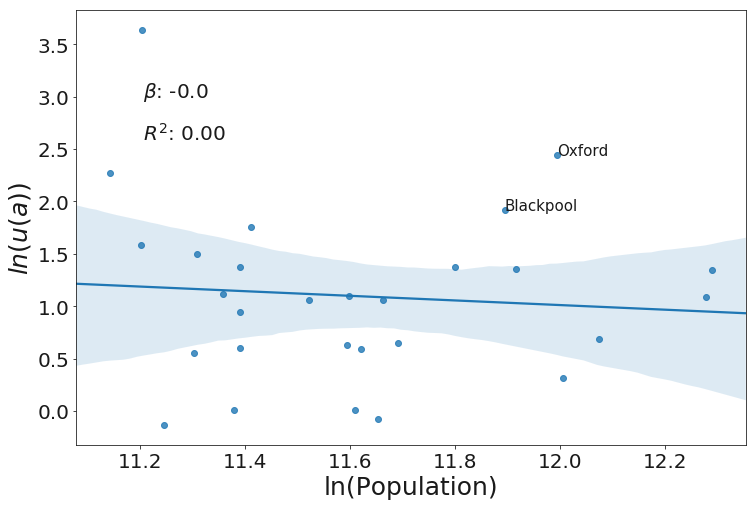

In [244]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
p = sns.regplot(x=predict_dosage,y=gt_dosage,ax=ax)
ax.set_xlabel("ln(Population)",fontsize=25)
ax.set_ylabel("$ln({u}(a))$",fontsize=25)
# ax.set_title("Opioids",fontsize=25)
plt.xticks(fontsize = 20 )
plt.yticks(fontsize = 20 )
label_point(predict_dosage , gt_dosage , names , ax)
ax.annotate(r"$\beta$" +": " +  str(slope_dosage)[:4], xy=(0.1, 0.8), xycoords='axes fraction',fontsize = 20)
# ax.annotate(r"$\alpha$" +": " +  str(intercept)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)
ax.annotate(r"$R^2$" +": " +  str(r_value_dosage**2)[:4], xy=(0.1, 0.7), xycoords='axes fraction',fontsize = 20)

In [98]:
city

{'Barnsley': 30845.6584463876,
 'Basildon': 42348.44002572297,
 'Basingstoke': 38888.680098802346,
 'Bath': 12544.08979935627,
 'Bedford': 13893.847676023475,
 'Birkenhead': 64019.4994789943,
 'Birmingham': 271424.7056001261,
 'Blackburn': 29896.134460876463,
 'Blackpool': 40869.35670685795,
 'Bolton': 112048.07644107298,
 'Bournemouth': 49600.94395814398,
 'Bracknell': 15745.330138563655,
 'Bradford': 101169.31299290528,
 'Brighton and Hove': 89870.67980852048,
 'Bristol': 199497.45236849826,
 'Burnley': 23368.10404202644,
 'Burton upon Trent': 16667.580126657733,
 'Bury': 28590.949676953252,
 'Cambridge': 32930.61627868646,
 'Carlisle': 29601.61887909033,
 'Chatham': 34768.521836482185,
 'Chelmsford': 50293.850051419184,
 'Cheltenham': 35556.13427330427,
 'Chester': 27657.509594239153,
 'Chesterfield': 30862.980736907502,
 'Colchester': 33238.446947558885,
 'Coventry': 85151.47861795303,
 'Crawley': 17541.952682673436,
 'Darlington': 26059.625886606318,
 'Derby': 36159.790663077256,


In [99]:
keys = ['opioids']
allCosts = {}
for k in keys:
    allCosts[k] = 0.0
    for m in monthly_borough_savings[k]:
        allCosts[k]+= np.sum(monthly_borough_savings[k][m].values())
    

In [100]:
sum(allCosts.values())

7490771.694831205

In [101]:
monthly_borough_costs_slice = monthly_borough_costs['opioids']
monthly_borough_savings_slice = monthly_borough_savings['opioids']
monthly_borough_dosage_slice = monthly_borough_dosage['opioids']

In [102]:
total_monthly_costs = {}
for k in monthly_borough_costs_slice:
    total_monthly_costs[k] = {}
    for b in monthly_borough_costs_slice[k]:
        scale = float( population_borough[b])/1000.0
        total_monthly_costs[k][b] = monthly_borough_costs_slice[k][b]*scale
        
total_monthly_costs

KeyError: 'Kingston upon Hull'

In [ ]:
totalCost = {}
totalOverspend = {}
for k in monthly_borough_savings_slice:
    totalOverspend[k] = np.sum(monthly_borough_savings_slice[k].values())
    totalCost[k] = np.sum(total_monthly_costs[k].values())

In [ ]:
np.sum(totalCost.values()) , np.sum(totalOverspend.values())

In [ ]:
UKwide_opioid = {}
UKUKwide_opioid_costs = {}
for k in monthly_borough_savings_slice:
    UKwide_opioid[k] = sum(monthly_borough_savings_slice[k].values())
for k in monthly_borough_costs_slice:
    total = []
    for b in monthly_borough_costs_slice[k]:
        scale = float( population_borough[b])/1000.0
        total.append(monthly_borough_costs_slice[k][b]*scale)
    UKUKwide_opioid_costs[k] = total

In [ ]:
all_overspend = {}
all_overspend['savings'] = totalOverspend
all_overspend['costs'] = totalCost

In [ ]:
# all_overspend

In [ ]:
# %store opioid_overspend
# %store all_overSpend

In [ ]:
# all_monthly_borough_savings = monthly_borough_savings

# %store all_monthly_borough_savings
# %store -r monthly_borough_savings

In [ ]:
# %store -r monthly_borough_savings

In [ ]:
IMD_District = json.load(open('District_IMD_scores_life_values.json','rb'))

In [ ]:
IMD_District['Wirral']

In [ ]:
savings = {}
for month in monthly_borough_savings_slice:
    for dist in monthly_borough_savings_slice[month]:
        if dist not in savings:
            savings[dist] = 0.0
        else:
            savings[dist]+=monthly_borough_savings_slice[month][dist]
dose = {}
for month in monthly_borough_dosage_slice:
    for dist in monthly_borough_dosage_slice[month]:
        if dist not in dose:
            dose[dist] = 0.0
        else:
            dose[dist]+=monthly_borough_dosage_slice[month][dist]

cost = {}
for month in total_monthly_costs:
    for dist in total_monthly_costs[month]:
        if dist not in cost:
            cost[dist] = 0.0
        else:
            cost[dist]+=total_monthly_costs[month][dist]

            
dict_saving = {'Name':[],'Savings':[] , 'Dosage':[] , 'Density' : [] , 'Seniors' : [] , 'IMD' : [] , 'TotalCost':[]}
for s in savings:
    dict_saving['Name'].append(s)
    dict_saving['Savings'].append(savings[s])
    dict_saving['TotalCost'].append(cost[s])
    dict_saving['Dosage'].append(dose[s])
    dict_saving['Density'].append(IMD_District[s]['pop_density'])
    dict_saving['Seniors'].append(IMD_District[s]['senior_pop'])
    dict_saving['IMD'].append(IMD_District[s]['aggregate_IMD'])



savings_df = pd.DataFrame(dict_saving)

In [ ]:
savings_df

In [ ]:
england = gp.read_file('../BL_Work/Local_Authority_Districts_December_2017_Ultra_Generalised_Clipped_Boundaries_in_United_Kingdom_WGS84.shp')

In [ ]:
england.head()

In [ ]:
merged = england.set_index('lad17nm').join(savings_df.set_index('Name'))
merged = merged[np.isfinite(merged['Savings'])]

In [ ]:
merged

In [ ]:
merged.to_csv('anti_dep_borough_2016_data.csv')

In [ ]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Savings'
vmin, vmax = min(savings_df['Savings']) , max(savings_df['Savings'])

fig, ax = plt.subplots(1, figsize=(18, 12))
merged.plot(column=variable, cmap='Reds', linewidth=1, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Overspending for opioids', fontdict={'fontsize': 25, 'fontweight' : 20})
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.yaxis.offsetText.set(size=20)
cbar.ax.tick_params(labelsize=30) 

In [ ]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'Dosage'
vmin, vmax = min(savings_df['Dosage']) , max(savings_df['Dosage'])

fig, ax = plt.subplots(1, figsize=(18, 12))
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')
ax.axis('off')
ax.set_title('Normalized dosages per 1000 (2010-2019)', fontdict={'fontsize': 25, 'fontweight' : 5})
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

In [ ]:
standardized_merged = merged.copy()

In [ ]:
def normalize(df,feature_names):
    result = df.copy()
    for feature_name in feature_names:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [ ]:
standardized_merged = normalize(merged , ['Savings','Density','Dosage','IMD','Seniors'])

In [ ]:
standardized_merged.head()

In [ ]:
corr = pearsonr(standardized_merged['Dosage'], standardized_merged['IMD'])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Dosage',y='IMD',data=standardized_merged)
ax.set_title("IMD Vs Relative normalized dosage for Anti depressants" , fontsize=20)
ax.set_xlabel("Relative normalized dosage",fontsize=20)
ax.set_ylabel("Normalized IMD",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)


In [ ]:
corr = pearsonr(standardized_merged['Savings'], standardized_merged['IMD'])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='IMD',data=standardized_merged)
ax.set_title("IMD Vs Overspending across all Drugs" , fontsize=20)
ax.set_xlabel("Normalized Overspending",fontsize=20)
ax.set_ylabel("Normalized IMD",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)


In [ ]:
corr = pearsonr(standardized_merged['Savings'], standardized_merged['Seniors'])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='Seniors',data=standardized_merged)
ax.set_title("Senior population Vs Savings from Generics: Opioids" , fontsize=20)
ax.set_xlabel("Normalized Savings",fontsize=20)
ax.set_ylabel("Normalized Senior population",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.2),fontsize = 18)

In [ ]:
corr=pearsonr(standardized_merged['Savings'], standardized_merged['Density'])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Savings',y='Density',data=standardized_merged)
ax.set_title("Population density Vs Overspending" ,fontsize=20)
ax.set_xlabel("Normalized Overspending",fontsize=20)
ax.set_ylabel("Normalized population density",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.8),fontsize = 18)

In [ ]:
corr=pearsonr(standardized_merged['Dosage'], standardized_merged['Density'])

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.regplot(x='Dosage',y='Density',data=standardized_merged)
ax.set_title("Population density Vs Relative Normalized dosage for Anti-depressants" ,fontsize=20)
ax.set_xlabel("Relative normalized  dosage",fontsize=20)
ax.set_ylabel("Normalized population density",fontsize=20)
ax.annotate("Corr: " +  str(corr[0])[:4],  xy=(0.8, 0.8),fontsize = 18)


In [ ]:
pearsonr(standardized_merged['Dosage'], standardized_merged['Seniors'])

In [ ]:
sns.regplot(x='Savings',y='Seniors',data=standardized_merged)

In [ ]:
monthlySavings = {}
for k in monthly_borough_savings:
    monthlySavings[k] = np.median(monthly_borough_savings[k].values())
    
    
monthlyCosts = {}
for k in monthly_borough_costs:
    monthlyCosts[k] = np.median(monthly_borough_costs[k].values())

In [ ]:
months = sorted(all_overspend['savings'].keys())

In [ ]:
overspend = [all_overspend['savings'][k]/1000000.0 for k in months]

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(18, 10)
sns.set_style("white")
sns.lineplot(y=overspend,x=np.arange(0,len(months),1))
# sns.lineplot(y=savings_df['diabetes_over'],x=np.arange(0,len(savings_df),1))
# sns.lineplot(y=savings_df['opioid_over'],x=np.arange(0,len(savings_df),1))
ax = plt.gca()

# plt.xticks(np.arange(0,len(months)+1, 2.0))
labels= [months[2*i] for i in range(0,len(months)/2)]
plt.xticks(np.arange(0,len(months) ,2),labels,rotation=90,fontsize= 15)
plt.yticks(fontsize= 15)
# plt.legend(['Overspending for Depression', 'Overspending for Diabetes', 'Overspending for Opioids'], fontsize = 16)
plt.xlabel("Year and month  (YYYYMM) ",fontsize=20)
plt.ylabel("Overspending in Million Sterling pounds",fontsize=20)
